# Behavioral Cloning

Using Deep neural networks, The steering wheel of the car in a simulated environment is trained and deployed. The reference used for this projects 
- [End to End Learning for Self-Driving Cars by NVIDIA](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf)
- [Reference Implementation](https://github.com/hortovanyi/udacity-behavioral-cloning-project)
- [Udacity Reference](https://github.com/udacity/CarND-Behavioral-Cloning-P3)

# Project Requirements

- Use the simulator to collect data of good driving behavior
- Build, a convolution neural network in Keras that predicts steering angles from images
- Train and validate the model with a training and validation set
- Test that the model successfully drives around track one without leaving the road
- Summarize the results with a written report


# Data Exploration
Simulator stores the images on the directory and it logs the path of the image with other inputs in a CSV File.

There were issues in parsing the information from udacity csv file and the one generated by the simulator. Turns out to be the first row is an issue. For training and validation purpose the first row has been eliminated and hardcoded for easy accesibility.

In [73]:

import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
from scipy.stats import norm
%matplotlib inline


columns = ['center', 'left', 'right','steering', 'throttle', 'brake', 'speed']
path = './data'
df = pd.read_csv(path+'/driving_log.csv',names=columns)
df.describe()

,steering,throttle,brake,speed
count,6613.000000,6613.000000,6613.000000,6.613000e+03
mean,-0.037714,0.438229,0.002797,2.285011e+01
std,0.204805,0.456160,0.038089,7.791262e+00
min,-1.000000,0.000000,0.000000,2.175237e-07
25%,-0.029307,0.000000,0.000000,1.650241e+01
50%,0.000000,0.225300,0.000000,2.537580e+01
75%,0.000000,1.000000,0.000000,3.017953e+01
max,1.000000,1.000000,0.902862,3.044908e+01


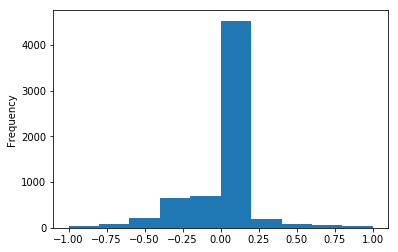

In [74]:
df['steering'].plot.hist(bins=10)

Most of the data points are almost equal to zero because the car was driving straight with no modification in the steering wheel. In the mean time the track itself has more left turns compared to right turns, so the data set seems to have more negative(left) values. This issue was solved by driving the car in opposite direction of the track.

In [75]:
path = './data_5'
df = pd.read_csv(path+'/driving_log.csv',names=columns)
df.describe()

,steering,throttle,brake,speed
count,1061.000000,1061.000000,1061.000000,1061.000000
mean,0.100029,0.217519,0.029581,12.933515
std,0.604936,0.398597,0.165802,6.322696
min,-1.000000,0.000000,0.000000,0.000180
25%,-0.250000,0.000000,0.000000,8.887391
50%,0.000000,0.000000,0.000000,12.235730
75%,0.600000,0.000000,0.000000,16.730840
max,1.000000,1.000000,1.000000,30.607920


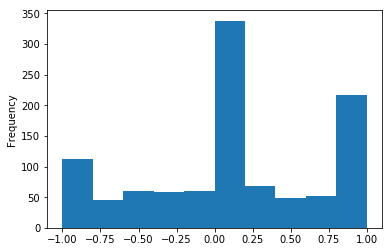

In [76]:
df['steering'].plot.hist(bins=10)

More samples were taken upon performance. The data was collected with some noise information like not going in a straight line on a straight road. Just to make the data diverse.

In [77]:
#Importing Libraries
import numpy as np
import pandas as pd
import cv2
import json
import tensorflow as tf
import random
from pathlib import PurePosixPath
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers import Convolution2D
from keras.optimizers import Adam
from keras.utils.visualize_util import plot
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

## Function to Load image from the log files

NVIDIA model uses YUV Plane. So I decided to use YUV plane for this model. The image stored by the simulator is RGB, SO the load image function takes care of the color conversion.

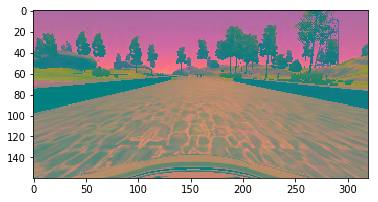

In [78]:
def load_image(path, filename):
    filename = filename.strip()
    if filename.startswith('IMG'):
        filename = path+'/'+filename
    else:
        filename = path+'/IMG/'+PurePosixPath(filename).name
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

path = './udacity_data'
df = pd.read_csv(path+'/driving_log.csv',names=columns)
img = load_image(path,df["center"][2])
plt.imshow(img)

Informations like the Sky and the car front is actually not needed for the model, So we can crop the information. 

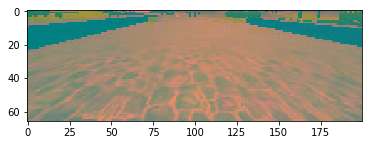

In [79]:

def crop_camera(img, crop_height=66, crop_width=200):
    height = img.shape[0]
    width = img.shape[1]
    y_start = 60
    x_start = int(width/2)-int(crop_width/2)
    return img[y_start:y_start+crop_height, x_start:x_start+crop_width]

cropped_img = crop_camera(img)
plt.imshow(cropped_img)

# Data Augmetation
> - We have a little data and we want to train a bigger model, So a data augmentation technique from the link has been used [According to this post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) [this post](https://github.com/hortovanyi/udacity-behavioral-cloning-project/blob/master/behavorial-cloning-initial-data-exploration.ipynb)

Image data has been transformed and the steering angle was also modified according to warp transformation of the image. Image brightness adjustment has been done on HSV space and converted back to YUV

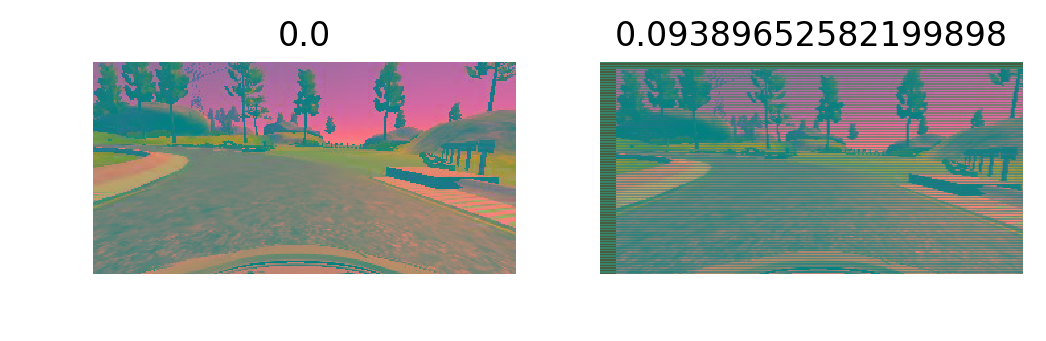

In [80]:
def jitter_image_rotation(image, steering):
    rows, cols, _ = image.shape
    transRange = 100
    numPixels = 10
    valPixels = 0.4
    transX = transRange * np.random.uniform() - transRange/2
    steering = steering + transX/transRange * 2 * valPixels
    transY = numPixels * np.random.uniform() - numPixels/2
    transMat = np.float32([[1, 0, transX], [0, 1, transY]])
    image = cv2.warpAffine(image, transMat, (cols, rows))
    return image, steering

def randomise_image_brightness(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_YUV2BGR)
    hsv = cv2.cvtColor(rgb, cv2.COLOR_BGR2HSV)
    bv = .25 + np.random.uniform()
    hsv[::2] = hsv[::2]*bv
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    yuv = cv2.cvtColor(rgb, cv2.COLOR_BGR2YUV)
    return yuv


def jitter_camera_image(row, log_path, cameras):
    steering = getattr(row, 'steering')

    # use one of the cameras randomily
    camera = cameras[random.randint(0, len(cameras)-1)]
    steering += steering_offset[camera]

    image = load_image(log_path, getattr(row, camera))
    image, steering = jitter_image_rotation(image, steering)
    image = randomise_image_brightness(image)

    return image, steering



logdata=df.iloc[5]
img1 = load_image(path, logdata.center)
steering1 = float(logdata.steering)
img2, steering2 = jitter_image_rotation(img1, steering1)
img2 = randomise_image_brightness(img2)
fig = plt.figure(dpi=200)
fig.add_subplot(221)
plt.title(steering1)
plt.axis('off')
plt.imshow(img1)
fig.add_subplot(222)
plt.title(steering2)
plt.axis('off')
plt.imshow(img2)

# Data Generator
Since our data is huge, it is hard to maintain all the data at the memory. So we need a generator function to give just the batch of data. This comes convenient for training big data models.

In [81]:
cameras = ['left', 'center', 'right']
def gen_train_data(path='./data', log_file='driving_log.csv', skiprows=1,
                   cameras=cameras, batch_size=128):

    # load the csv log file
    print("Cameras: ", cameras)
    print("Log path: ", path)
    print("Log file: ", log_file)

    column_names = ['center', 'left', 'right',
                    'steering', 'throttle', 'brake', 'speed']
    data_df = pd.read_csv(path+'/'+log_file,
                          names=column_names, skiprows=skiprows)
    data_count = len(data_df)

    print("Data in Log, %d rows." % (len(data_df)))

    while True:
        features = []
        labels = []
        #Choosing random samples  
        
        while len(features) < batch_size:
            row = data_df.iloc[np.random.randint(data_count-1)]

            image, steering = jitter_camera_image(row, path, cameras)

            if random.random() >= .5 and abs(steering) > 0.1:
                image = cv2.flip(image, 1)
                steering = -steering

            image = crop_camera(image)
            features.append(image)
            labels.append(steering)

        # yield the batch
        yield (np.array(features), np.array(labels))

# Model Architecture and Training Strategy
I started with NVIDIA model because that seems like a reasonable model to start. 


### Implementation notes
 - performed data augmentation by shifting the pixels and steering angles of the images.
 - Built a CNN to match the image input 66x200x3 and added 4 more CNNs according to NVIDIA model, and added dropout layers for better training of the model.
 - Modyfied the hyper parameters to get better results.
 - Training data affected the Performance a lot compared to other parameters
 - Drop out layer probability, did a huge improvement of the model.
 - Using Adam optimizer for the model because it is an efficient optimizer. The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients. [Ref](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)



| Layer | Input | Output  | Description | Filter Size |
|-------|-------|---------|-------------|--------------|
| CNN-1 | 66x200x3 | 31x98x24  | Input YUV Image with stride 2 and valid padding with elu activation| 5x5 |
| DO |  |  | DropOut |
| CNN-2 | 31x98x24 | 14x47x36  | CNN with stride 2 and valid padding with elu activation | 5x5 |
| DO |  |  | DropOut |
| CNN-3 | 14x47x36 | 5x22x48  | CNN with stride 2 and valid padding with elu activation | 5x5 |
| DO |  |  | DropOut |
| CNN-4 | 5x22x48 | 3x20x64  | CNN with stride 1 and valid padding with elu activation | 3x3 |
| DO |  |  | DropOut |
| CNN-5 | 3x20x64 | 1x18x64  | CNN with stride 1 and valid padding with elu activation | 3x3 |
| DO |  |  | DropOut |
| Flatten | 1x18x64 | 1152  | Flatten the layer |
| DO |  |  | DropOut |
| FC-1 | 1152 | 100  | Fully connected Layer |
| DO |  |  | DropOut |
| FC-2 | 100 | 50  | Fully connected Layer |
| DO |  |  | DropOut |
| FC-3 | 50 | 10  | Fully connected Layer |
| DO |  |  | DropOut |
| FC-4 | 10 | 1  | Fully connected Layer |


In [82]:

def build_nvidia_model(img_height=66, img_width=200, img_channels=3,
                       dropout=.5):

    # build sequential model
    model = Sequential()

    # normalisation layer
    img_shape = (img_height, img_width, img_channels)
    model.add(Lambda(lambda x: x * 1./127.5 - 1,
                     input_shape=(img_shape),
                     output_shape=(img_shape), name='Normalization'))

    # convolution layers with dropout
    nb_filters = [24, 36, 48, 64, 64]
    kernel_size = [(5, 5), (5, 5), (5, 5), (3, 3), (3, 3)]
    same, valid = ('same', 'valid')
    padding = [valid, valid, valid, valid, valid]
    strides = [(2, 2), (2, 2), (2, 2), (1, 1), (1, 1)]

    for l in range(len(nb_filters)):
        model.add(Convolution2D(nb_filters[l],
                                kernel_size[l][0], kernel_size[l][1],
                                border_mode=padding[l],
                                subsample=strides[l],
                                activation='elu'))
        model.add(Dropout(dropout))

    # flatten layer
    model.add(Flatten())

    # fully connected layers with dropout
    neurons = [100, 50, 10]
    for l in range(len(neurons)):
        model.add(Dense(neurons[l], activation='elu'))
        model.add(Dropout(dropout))

    # logit output - steering angle
    model.add(Dense(1, activation='elu', name='Out'))

    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer,
                  loss='mse')
    return model

In [83]:
model = build_nvidia_model()
for l in model.layers:
    print(l.name, l.input_shape, l.output_shape,
    l.activation if hasattr(l, 'activation') else 'none')
plot(model, to_file='model.jpg', show_shapes=True)
print(model.summary())

Normalization (None, 66, 200, 3) (None, 66, 200, 3) none
convolution2d_11 (None, 66, 200, 3) (None, 31, 98, 24) <function elu at 0x7fc5f8adbd90>
dropout_17 (None, 31, 98, 24) (None, 31, 98, 24) none
convolution2d_12 (None, 31, 98, 24) (None, 14, 47, 36) <function elu at 0x7fc5f8adbd90>
dropout_18 (None, 14, 47, 36) (None, 14, 47, 36) none
convolution2d_13 (None, 14, 47, 36) (None, 5, 22, 48) <function elu at 0x7fc5f8adbd90>
dropout_19 (None, 5, 22, 48) (None, 5, 22, 48) none
convolution2d_14 (None, 5, 22, 48) (None, 3, 20, 64) <function elu at 0x7fc5f8adbd90>
dropout_20 (None, 3, 20, 64) (None, 3, 20, 64) none
convolution2d_15 (None, 3, 20, 64) (None, 1, 18, 64) <function elu at 0x7fc5f8adbd90>
dropout_21 (None, 1, 18, 64) (None, 1, 18, 64) none
flatten_3 (None, 1, 18, 64) (None, 1152) none
dense_7 (None, 1152) (None, 100) <function elu at 0x7fc5f8adbd90>
dropout_22 (None, 100) (None, 100) none
dense_8 (None, 100) (None, 50) <function elu at 0x7fc5f8adbd90>
dropout_23 (None, 50) (None,

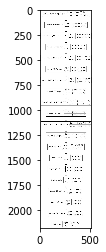

In [84]:
plt.imshow(cv2.imread('model.jpg'))
#model from keras graphics

I started with this reference [implementation](https://github.com/hortovanyi/udacity-behavioral-cloning-project), and the model doesn't seem to work great with RGB space, I even tried grayscale and that doesnt seem to give good outputs. Obviously the color information is an important feature for this steering angle prediction. According to my mentor's input and NVIDIA's reference I changed the color space to YUV. The model seems to perform little better. 

P.S - I have been feeding a lot of data, by changing the direction of the track and having a zigzag motion on a staight road. This seems to affect the prediction a lot more compared to other factors.

The more I fed the data, the better the model became. When I give wrong data, The model performed poorly.

# Conclusion
- I trained it about 15 times with different data. when I see the car going offlane, I go to that spot in the track and record more information. Drop off percentage was adjusted when I was doing the changes. If I don't do that, the existing model doesnt perform well.
- I used Udacity's data as the validation set. I know the data that I am collecting is not ideal. So I just took the whole udacity data as validation set.
- The loss percentage was well below 0.2 at the start and it was dropped to 0.04.
- I had early stopping enabled on the model. From What I observed, around 5 epochs is good to reach a stable state.
- I used Adam optimizer so the learning rate was not adjusted manually
